In [2]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
sys.path.insert(0, '/Users/weilu/Research/opt_server/')
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
interaction_index_dic

{'anti_0': 6,
 'anti_1': 50,
 'anti_10': 41,
 'anti_100': 15,
 'anti_101': 50,
 'anti_102': 50,
 'anti_103': 50,
 'anti_104': 50,
 'anti_105': 46,
 'anti_106': 50,
 'anti_107': 50,
 'anti_108': 50,
 'anti_109': 34,
 'anti_11': 50,
 'anti_110': 50,
 'anti_111': 50,
 'anti_112': 50,
 'anti_113': 50,
 'anti_114': 50,
 'anti_115': 50,
 'anti_116': 50,
 'anti_117': 50,
 'anti_118': 50,
 'anti_119': 50,
 'anti_12': 50,
 'anti_120': 50,
 'anti_121': 50,
 'anti_122': 50,
 'anti_123': 50,
 'anti_124': 50,
 'anti_125': 50,
 'anti_126': 50,
 'anti_127': 50,
 'anti_128': 50,
 'anti_129': 50,
 'anti_13': 50,
 'anti_130': 50,
 'anti_131': 50,
 'anti_132': 50,
 'anti_133': 50,
 'anti_134': 50,
 'anti_135': 50,
 'anti_136': 50,
 'anti_137': 50,
 'anti_138': 50,
 'anti_139': 50,
 'anti_14': 50,
 'anti_140': 23,
 'anti_141': 50,
 'anti_142': 50,
 'anti_143': 50,
 'anti_144': 33,
 'anti_145': 50,
 'anti_146': 50,
 'anti_147': 30,
 'anti_148': 50,
 'anti_149': 5,
 'anti_15': 12,
 'anti_150': 42,
 'anti_15

In [166]:
# res to index
# index_dic
info = pd.read_csv("/Users/weilu/Research/database/gxxxg_index_dic_v4.csv", index_col=0)
interaction_index_dic = {}
n = 50
for i, line in info.iterrows():
    # print(i, line["i"])
    if line["index"] < n:
        interaction_index_dic[f"{line['Direction']}_{line['i']}"] = line["index"]
    else:
        interaction_index_dic[f"{line['Direction']}_{line['i']}"] = n

from Bio.PDB.Polypeptide import one_to_index
from Bio.PDB.Polypeptide import three_to_index

def get_400_based_index(res1_1, res1_2):
    index = three_to_index(res1_1)*20 + three_to_index(res1_2)
    return index
def get_overall_index_v4(index1, index2, direction, interaction_index_dic):
    n = 51
    # plus 1, total parameters. (51+1)*51/2 = 1326
    n_shift = 1326
    new_index1 = interaction_index_dic[f"{direction}_{index1}"]
    new_index2 = interaction_index_dic[f"{direction}_{index2}"]
    if new_index1 > new_index2:
        new_index1, new_index2 = new_index2, new_index1
    overall_index = ((2*n-(new_index1-1))*(new_index1)/2 + new_index2 - new_index1)
    if direction == "anti":
        overall_index += n_shift
    return int(overall_index)

def get_interaction_index_from_four_residues_v4(res1_1, res1_2, res2_1, res2_2, direction, interaction_index_dic=interaction_index_dic):
    # n_shift is 1326 when we use top 50
    # plus 1, total parameters. (51+1)*51/2 = 1326
    index1 = get_400_based_index(res1_1, res1_2)
    if direction == "parallel":
        index2 = get_400_based_index(res2_1, res2_2)
    elif direction == "anti":
        index2 = get_400_based_index(res2_2, res2_1)
    else:
        print("unknown direction")
        raise
    index = get_overall_index_v4(index1, index2, direction, interaction_index_dic)

    return index

def compute_gxxxg_energy(structure, gamma, get_interaction_index, n_parameters=2652, sequence=None):
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    if sequence is None:
        sequence = get_sequence_from_structure(structure)

    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    kappa = 5
    # n_parameters = 1 + max(interaction_index_dic.values()) + 1
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)

    e_gxxxg = 0.0
    e_gxxxg_parallel = 0.0
    e_gxxxg_anti_parallel = 0.0

    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    sep = res1globalindex - res2globalindex
                elif direction == "anti":
                    sep = res1globalindex - res2_2_globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and res2globalindex > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
    #                 if rij_2 > (r_max+2):
    #                     continue
                    resName_1_1 = one_to_three(sequence[res1globalindex])
                    resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                    resName_2_1 = one_to_three(sequence[res2globalindex])
                    resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                    # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                    # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                    interaction_index = get_interaction_index(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    if shift_to_res2_2 == -4:
                        e_gxxxg_anti_parallel += gamma[interaction_index] * phi_
                    else:
                        e_gxxxg_parallel += gamma[interaction_index] * phi_
                    # print(res1globalindex, res2globalindex, resName_1_1, resName_2_1, gamma[interaction_index], phi_)
    e_gxxxg = e_gxxxg_parallel + e_gxxxg_anti_parallel
    return e_gxxxg

In [167]:
gamma = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/top50_cutoff300.dat")

# make sure the python method gives the same energy as the openAWSEM

In [168]:

protein = "1py6"
# fileLocation = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat"
# gamma = np.loadtxt(fileLocation)
pre = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/{protein}"
sequence = read_fasta(f"{pre}/crystal_structure.fasta")

pdb = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/{protein}"
structure = parse_pdb(pdb)
compute_gxxxg_energy(structure, -gamma, get_interaction_index_from_four_residues_v4, n_parameters=2652, sequence=sequence)

-167.87318029890957

In [9]:
d = pd.read_csv("/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run3_top50/1py6/0/info.dat", sep="\s+")
d.head(2)

,Steps,Q,Rg,GXXXG,CBD_excl,S_chain,Helix_ori,Backbone,Rama,Contact,Fragment,Membrane,ER,TBM_Q,Beta,Pap,Helical,P_inside,Total
0,0,1.00,17.77,-167.86,104.59,-229.14,0.0,1195.87,-1470.31,-239.66,-1117.24,-302.35,0.0,57.91,0.0,0.0,0.0,37.59,-1875.77
1,1,0.97,17.88,-176.13,29.62,-412.34,0.0,148.43,-1673.56,-306.02,-1058.33,-306.82,0.0,5.14,0.0,0.0,0.0,37.98,-3191.17


# make sure the python method gives the same energy as the phi method

In [169]:
def phi_debug(structure, gamma, get_interaction_index, n_parameters=2652, sequence=None):
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    if sequence is None:
        sequence = get_sequence_from_structure(structure)

    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    kappa = 5
    # n_parameters = 1 + max(interaction_index_dic.values()) + 1
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)

    e_gxxxg = 0.0
    e_gxxxg_parallel = 0.0
    e_gxxxg_anti_parallel = 0.0
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    sep = res1globalindex - res2globalindex
                elif direction == "anti":
                    sep = res1globalindex - res2_2_globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and res2globalindex > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
    #                 if rij_2 > (r_max+2):
    #                     continue
                    resName_1_1 = one_to_three(sequence[res1globalindex])
                    resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                    resName_2_1 = one_to_three(sequence[res2globalindex])
                    resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                    # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                    # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                    interaction_index = get_interaction_index(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_
                    # print(res1globalindex, res2globalindex, resName_1_1, resName_2_1, gamma[interaction_index], phi_)
    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(round(phi_gxxxg_well[i],4))
    return phis_to_return

In [170]:

protein = "1ih5"

# fileLocation = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/gxxxg_701.dat"
# gamma = np.loadtxt(fileLocation)
# pre = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/run1/{protein}"
fastaFile = f"/Users/weilu/Research/server/jul_week1_2020/top50_among400_shuffle_optimization/database/S20_seq/{protein}.seq"
sequence = read_fasta(fastaFile)
pdb = f"/Users/weilu/Research/server/jul_week1_2020/top50_among400_shuffle_optimization/database/dompdb/{protein}"
# pdb = f"/Users/weilu/Research/server/jul_week1_2020/membrane_protein_structure_prediction/cleaned_pdbs/{protein}"
structure = parse_pdb(pdb)
# compute_gxxxg_energy(structure, -gamma, get_interaction_index_from_four_residues_v4, n_parameters=2652, sequence=sequence)
my_new_phi = phi_debug(structure, -gamma, get_interaction_index_from_four_residues_v4, n_parameters=2652, sequence=sequence)



In [171]:
energy = np.dot(gamma, my_new_phi)
print(energy)

230.69996967558504


In [162]:

# protein = "6pb0"
native_phi = np.loadtxt(f"/Users/weilu/Research/server/jul_week1_2020/top50_among400_shuffle_optimization/phis/phi_gxxxg_v4_well_{protein}_native_50")
energy = np.dot(gamma, native_phi)
print(energy)

252.44857020501257


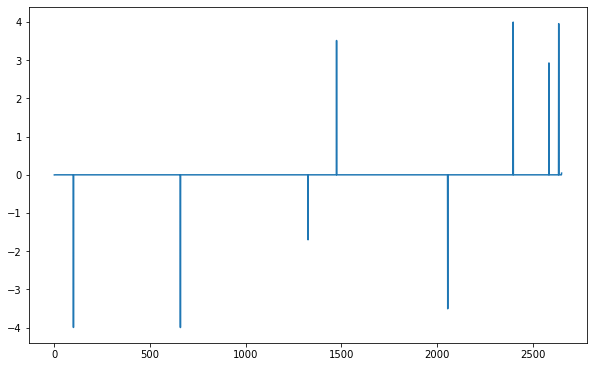

In [20]:
plt.plot(native_phi-my_new_phi)

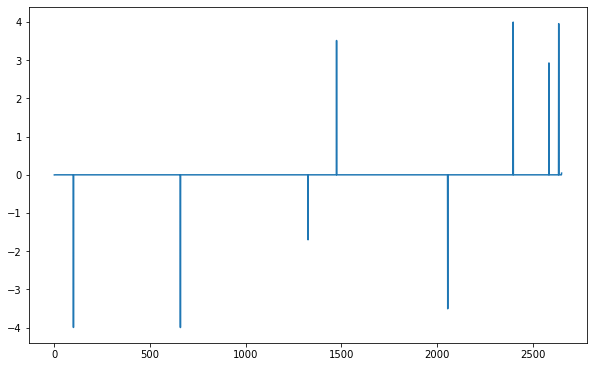

In [14]:
plt.plot(native_phi-my_new_phi)

In [173]:
def phi_gxxxg_v4_well(res_list, neighbor_list, parameter_list):
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    r_cutoff = 8.5
    kappa = 5
    n_parameters = 2652
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_cutoff):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    group2index = res2globalindex
                elif direction == "anti":
                    group2index = res2_2_globalindex
                sep = group2index - res1globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and group2index > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                    if rij_2 > r_cutoff or rij > r_cutoff:
                        continue
                    resName_1_1 = one_to_three(sequence[res1globalindex])
                    resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                    resName_2_1 = one_to_three(sequence[res2globalindex])
                    resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                    # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                    # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                    interaction_index = get_interaction_index_from_four_residues_v4(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_

    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(round(phi_gxxxg_well[i],4))
    return phis_to_return

In [174]:
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
my_phi = phi_gxxxg_v4_well(res_list, neighbor_list, "")

In [175]:
energy = np.dot(gamma, my_phi)
print(energy)

230.69996967558504


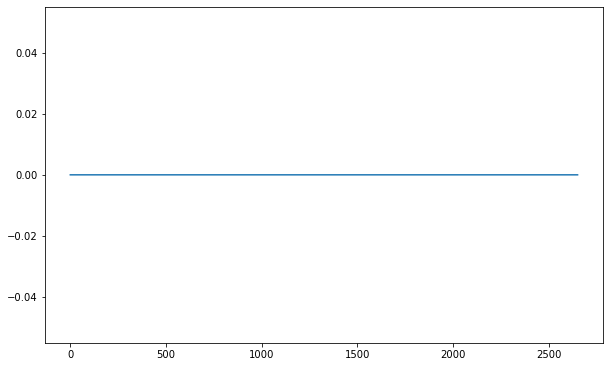

In [176]:
plt.plot(np.array(my_phi)-my_new_phi)

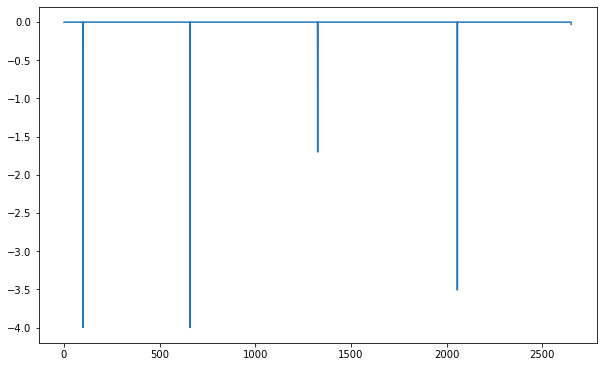

In [150]:
plt.plot(np.array(my_phi)-my_new_phi)

In [144]:
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
my_phi, info_rev = phi_gxxxg_v4_well(res_list, neighbor_list, "", mode=1)

44 48 6 2 anti A A
44 48 6 10 parallel A A


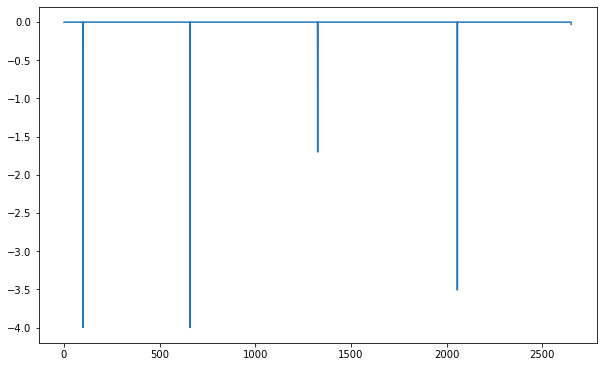

In [145]:
plt.plot(np.array(my_phi)-my_new_phi)

In [146]:
info_rev

,res1,res1_2,res2,res2_2,direction,sep,chain1,chain2,index,rij,rij_2,phi
0,28,32,22,18,anti,10,A,A,2636,7.904495,5.260393,7.949746e-07
1,28,32,21,17,anti,11,A,A,2546,6.230377,8.338035,9.753586e-09
2,31,35,21,17,anti,14,A,A,2546,5.214903,5.244561,9.999938e-01
3,32,36,22,18,anti,14,A,A,2211,5.143702,7.501219,4.484779e-05
4,32,36,18,14,anti,18,A,A,2216,5.260393,6.711645,1.075079e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
795,744,748,678,682,parallel,66,D,D,244,4.675537,4.949372,9.999998e-01
796,744,748,679,683,parallel,65,D,D,335,4.325820,5.116829,9.999990e-01
797,744,748,682,686,parallel,62,D,D,1325,6.185864,5.212131,9.585644e-01
798,744,748,625,629,parallel,119,D,D,1325,7.772593,7.108349,6.763673e-09


In [147]:
info_new

,res1,res1_2,res2,res2_2,direction,sep,chain1,chain2,index,rij,rij_2,phi
0,2,6,47,43,anti,41,A,A,2186,5.700266,7.207641,8.438075e-04
1,3,7,48,52,parallel,45,A,A,1325,5.846793,8.472085,2.720906e-09
2,3,7,49,53,parallel,46,A,A,1325,7.446269,6.330396,6.565066e-05
3,3,7,47,43,anti,40,A,A,2186,6.704918,7.049723,4.658314e-04
4,3,7,73,77,parallel,70,A,A,1325,5.802066,5.193074,9.990678e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
795,702,706,713,717,parallel,11,D,D,1325,4.622245,8.195115,4.347177e-08
796,710,714,733,737,parallel,23,D,D,1325,5.906067,6.350241,8.150678e-01
797,711,715,733,737,parallel,22,D,D,1325,8.213626,6.211715,3.421097e-08
798,714,718,737,733,anti,19,D,D,2651,6.350241,4.979508,8.172144e-01


In [67]:
res2 = res_list[6]
res2globalindex = get_global_index(res_list, res2)
res2chain = get_chain(res2)

In [70]:
res2_2_globalindex = res2globalindex - 4

In [73]:
res2_2_globalindex

2

In [72]:
get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)

<Residue ARG het=  resseq=12 icode= >

In [109]:
info_rev

,res1,res1_2,res2,res2_2,direction,sep,chain1,chain2,index,rij,rij_2,phi
0,13,17,672,676,parallel,-659,A,D,197,4.678756,7.570251,2.248798e-05
1,17,21,704,700,anti,-683,A,D,1362,5.119719,8.256120,2.361922e-08
2,20,24,704,708,parallel,-684,A,D,100,5.729936,5.207594,9.995452e-01
3,24,28,707,703,anti,-679,A,D,2651,4.651536,7.894784,8.760487e-07
4,26,30,407,403,anti,-377,A,C,2375,7.666035,8.487504,2.015345e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
855,744,748,678,682,parallel,66,D,D,244,4.675537,4.949372,9.999998e-01
856,744,748,679,683,parallel,65,D,D,335,4.325820,5.116829,9.999990e-01
857,744,748,682,686,parallel,62,D,D,1325,6.185864,5.212131,9.585644e-01
858,744,748,625,629,parallel,119,D,D,1325,7.772593,7.108349,6.763673e-09


In [116]:
info_new.query("res1==682")

,res1,res1_2,res2,res2_2,direction,sep,chain1,chain2,index,rij,rij_2,phi
794,682,686,744,748,parallel,62,D,D,1325,6.185864,5.212131,0.958564


In [110]:
info_new

,res1,res1_2,res2,res2_2,direction,sep,chain1,chain2,index,rij,rij_2,phi
0,2,6,47,43,anti,41,A,A,2186,5.700266,7.207641,8.438075e-04
1,3,7,48,52,parallel,45,A,A,1325,5.846793,8.472085,2.720906e-09
2,3,7,49,53,parallel,46,A,A,1325,7.446269,6.330396,6.565066e-05
3,3,7,47,43,anti,40,A,A,2186,6.704918,7.049723,4.658314e-04
4,3,7,73,77,parallel,70,A,A,1325,5.802066,5.193074,9.990678e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
795,702,706,713,717,parallel,11,D,D,1325,4.622245,8.195115,4.347177e-08
796,710,714,733,737,parallel,23,D,D,1325,5.906067,6.350241,8.150678e-01
797,711,715,733,737,parallel,22,D,D,1325,8.213626,6.211715,3.421097e-08
798,714,718,737,733,anti,19,D,D,2651,6.350241,4.979508,8.172144e-01


In [52]:
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
my_phi, info_another = phi_gxxxg_v4_well(res_list, neighbor_list, "")

In [84]:
info

,res1,res1_2,res2,res2_2,index,rij,rij_2,phi
0,1,5,750,746,1523,10.674837,12.809998,0.000000e+00
1,2,6,750,746,1523,9.169594,14.016174,0.000000e+00
2,2,6,751,747,2441,8.370478,9.440315,1.279391e-21
3,4,8,750,746,1494,10.994670,13.788776,0.000000e+00
4,5,9,750,746,1428,5.465016,10.785085,0.000000e+00
...,...,...,...,...,...,...,...,...
11081,747,751,678,674,2441,10.202799,19.269415,0.000000e+00
11082,747,751,678,682,207,10.202799,9.920990,7.703720e-32
11083,747,751,679,675,1356,6.400041,14.593873,0.000000e+00
11084,747,751,679,683,298,6.400041,9.068737,5.105331e-12


In [60]:
info.query("res1==44")

,res1,res1_2,res2,res2_2,index,rij,rij_2,phi
496,44,48,682,678,1475,9.319533,18.194630,0.0
497,44,48,682,686,1325,9.319533,12.965011,0.0
498,44,48,680,676,2651,9.740139,17.257454,0.0
499,44,48,680,684,1325,9.740139,15.530168,0.0
500,44,48,686,682,2651,7.191754,15.234429,0.0
501,44,48,686,690,1325,7.191754,24.255588,0.0
502,44,48,684,680,2651,8.314262,15.051648,0.0
503,44,48,684,688,1325,8.314262,20.826118,0.0
504,44,48,685,681,2651,10.490098,18.450491,0.0
505,44,48,685,689,1325,10.490098,20.738737,0.0


In [75]:
info_another.query("res2_2 == 44")

,res1,res1_2,res2,res2_2,index,rij,rij_2,phi
1,2,6,48,44,2651,8.301671,9.439091,2.577426e-21
7,3,7,48,44,2651,5.846793,11.913129,0.000000e+00
25,4,8,48,44,2216,9.789471,15.985315,0.000000e+00
40,5,9,48,44,1475,9.928362,11.294427,0.000000e+00
50,6,10,48,44,1661,4.423632,10.030828,4.440892e-16
68,7,11,48,44,2651,5.080990,14.954021,0.000000e+00
106,8,12,48,44,2651,11.377692,15.668141,0.000000e+00
131,9,13,48,44,1376,9.029824,13.369922,0.000000e+00
147,10,14,48,44,2123,6.549499,12.036223,0.000000e+00
154,10,14,40,44,807,7.360772,12.036223,0.000000e+00


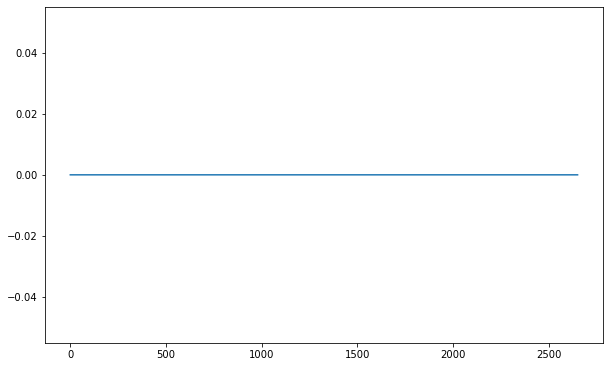

In [47]:
plt.plot(np.array(my_new_phi)-np.array(my_phi))

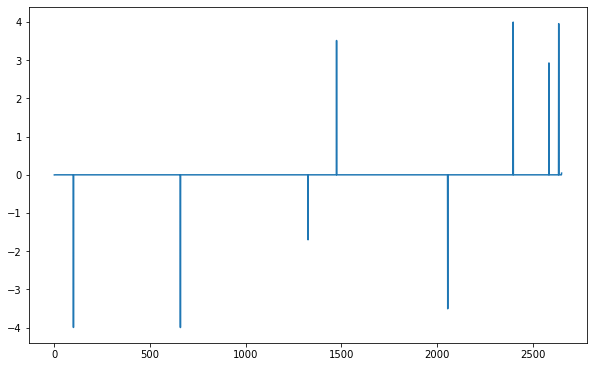

In [36]:
plt.plot(native_phi-my_phi)

In [ ]:
def phi_gxxxg_v4_well(res_list, neighbor_list, parameter_list, mode=0):
    info = []
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    kappa = 5
    n_parameters = 2652
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+10.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1globalindex == 44 and res2globalindex == 6:
                    print(res1globalindex, res1_2_globalindex, res2globalindex, res2_2_globalindex, direction, res1chain, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    group2index = res2globalindex
                elif direction == "anti":
                    group2index = res2_2_globalindex
                sep = group2index - res1globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and group2index > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                    if rij_2 > (r_max+2) or rij > (r_max+2):
                        continue
                    resName_1_1 = one_to_three(sequence[res1globalindex])
                    resName_1_2 = one_to_three(sequence[res1_2_globalindex])
                    resName_2_1 = one_to_three(sequence[res2globalindex])
                    resName_2_2 = one_to_three(sequence[res2_2_globalindex])
                    # interaction_index = get_interaction_index_from_four_residues(res1.resname, res1_2.resname, res2.resname, res2_2.resname)
                    # interaction_index = get_interaction_index_from_four_residues_v2(resName_1_1, resName_1_2, resName_2_1, resName_2_2)
                    interaction_index = get_interaction_index_from_four_residues_v4(resName_1_1, resName_1_2, resName_2_1, resName_2_2, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_
                    
                    info.append([res1globalindex, res1_2_globalindex, res2globalindex, res2_2_globalindex, direction, sep, res1chain, res2chain, interaction_index, rij, rij_2, phi_])
                # print(info_)
    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(round(phi_gxxxg_well[i],4))
    info = pd.DataFrame(info, columns=["res1", "res1_2", "res2", "res2_2", "direction", "sep", "chain1", "chain2", "index", "rij", "rij_2", "phi"])
    return phis_to_return, info